# Understanding the strategy

This notebook works through the basic concepts underpinning this strategy. 

The strategy follows the steps below:

1. Use 1 month of historical data to estimate the parameters of the model via Baysian inference an probabilistic programming. Use this to estimate the future distribution at a later time time $T$ over the S&P 500 index.
2. Using the estimated distribution, check that options prices 1 week out are priced efficiently to Black Scholes. 
3. Construct a Top Hat profit and loss curve using a combination of long and short puts and calls. 

### Some critical assumptions
We will assume that the evolution of the S&P 500 index over a short period of time obeys a geometric Brownian motion SDE with constant parameters
 $$d\log (S_t) = \left(\mu - \frac{\sigma^{2}}{2}\right)dt + \sigma dW_t$$

In [1]:
import numpy as np
import datetime as dt

from _fitting import *
from _utils import *

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 14

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/var/folders/k6/79gt8yds1l3gsjyykhx8fr4r0000gn/T/ipykernel_41935/2676093710.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [110]:
# Set ticker
ticker = "^GSPC"
option_ticker = "^SPX"

# set date range
ddays = 100
end_date = dt.datetime.today()
start_date = end_date - dt.timedelta(days=ddays)

# interval
interval = "1d"
dtime = int(interval[:-1])

# Get the data
data = get_stock_data(ticker, start_date, end_date, interval=interval)

# Compute log price and add days
data['log_close'] = np.log(data['Adj Close'])
data.index = data.index.date
data['days'] = (data.index - data.index[0]).days

#---------------------#
Getting underlying data for ticker:  ^GSPC
#---------------------#
[*********************100%***********************]  1 of 1 completed


In [111]:
# Get some rough estimates of mu and sigma
mu, sigma = estimate_coeffs(data['log_close'], len(data['log_close']), dtime)

print("mu: ", mu)
print("sigma: ", sigma)

mu:  0.00047442042948761873
sigma:  0.009661563024251814


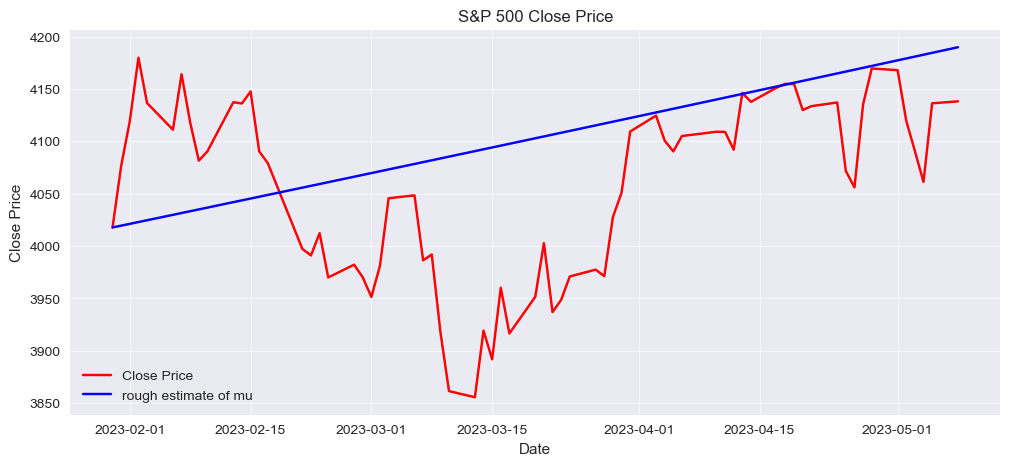

In [112]:
fig = plt.figure(figsize=(12, 5))
plt.plot(data.index, data["Close"], color='r', label="Close Price")

# Plot mu as a straight line with the date range
plt.plot(data.index, np.exp(data['log_close'][0] + (mu - 0.5* sigma**2) * data['days']), color='b', label="rough estimate of mu")

plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("S&P 500 Close Price")
plt.grid(linestyle='-', linewidth=0.5)
plt.legend()

plt.show()

# Use PYMC to estimate the parameters of the model

Here we are using Pymc to build a simple Bayseian model to estimate the parameters of the model. We will use the S&P 500 index as our data set.

Given the small data set we are including, we don't want to rely on naieve estimates of the parameters. Instead we will use a Bayseian approach to estimate the parameters of the model which will allow us to build in any uncertainty we have about the parameters.

In [113]:
# We now fit the geometric brownian motion model to the data
trace = fit_geometric_brownian_motion(data['Close'].values, [mu, np.abs(mu), sigma], 1)

/Users/michael/miniconda3/lib/python3.10/site-packages/pymc/distributions/timeseries.py:973: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100, shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, stock]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


# Plot the posterior distribution of the parameters

Below we are plotting the posterior distribution of the estimated parameters. This allows us to build in any uncertainty we have about the parameters. For short periods, the posterior of $\mu$ is approximately normal, whereas $\sigma$ is approximately log-normal.

In [114]:
# Plot the trace estimates of the posterior distribution
mu_post = trace.posterior.get("mu").values.flatten()
sigma_post = trace.posterior.get("sigma").values.flatten()

# Get the pdfs of posterieor distributions
mu_pdf_x, mu_pdf = normal_pdf(mu_post)
sigma_pdf_x, sigma_pdf = log_normal_pdf(sigma_post)

# Get mean and std of the posterior distributions
mu_mean, mu_std = np.mean(mu_post), np.std(mu_post)
sigma_mean, sigma_std = np.mean(sigma_post), np.std(sigma_post)

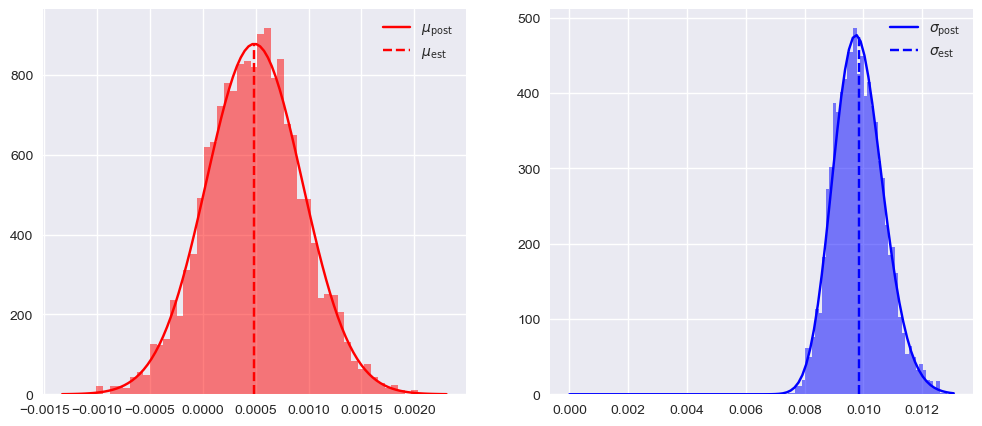

In [115]:
fig = plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(mu_pdf_x, mu_pdf, color='r', label=r"$\mu_{\rm post}$")
plt.vlines(mu_mean, 0, np.max(mu_pdf), color='r', linestyle='--', label=r"$\mu_{\rm est}$")
plt.hist(mu_post, bins=50, density=True, alpha=0.5, color='r')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(sigma_pdf_x, sigma_pdf, color='b', label=r"$\sigma_{\rm post}$")
plt.vlines(sigma_mean, 0, np.max(sigma_pdf), color='b', linestyle='--', label=r"$\sigma_{\rm est}$")
plt.hist(sigma_post, bins=50, density=True, alpha=0.5, color='b')
plt.legend()

plt.show()

# Making use of the marginal distribution

Now we want to compute the probability distribution over the future stock values given our distributions over $\mu$ and $\sigma$. This distribution is given by 
$$
P(s) = \int \int P(s|\mu,\sigma) P(\mu)P(\sigma) d\mu d\sigma
$$
This will allow us to construct the posterior estimate of the actuall distribution of the stock price at a later time $T$ given our uncertainty in the estimated parameters.

In [116]:
# We can now infer the future probability distribution of the stock price using bayesian inference
# Future time we are inetrested in 
T = 7

s_range = [data['Close'].values[-1]*0.7, data['Close'].values[-1]*1.3]
ds = 1
s, s_est = infer_stock_pdf(mu_post, sigma_post, data['Close'].values[-1], T, s_range, ds=ds)

# Compute mean and std of the inferred pdf
s_mean = np.sum(s*s_est)*ds
s_std = np.sqrt(np.sum(s**2*s_est)*ds - s_mean**2)


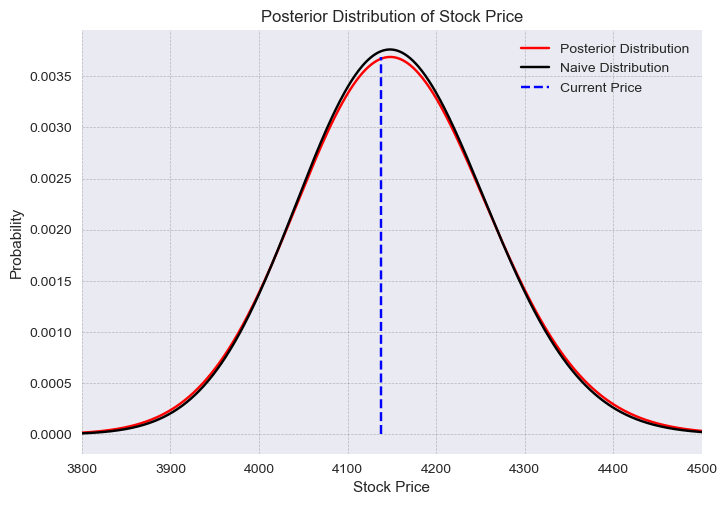

In [117]:
# Plot the posterior distribution
plt.plot(s, s_est, color='r', label="Posterior Distribution")
plt.plot(s, stock_pdf(s, data['Close'].values[-1], T, mu, sigma), color='k', label="Naive Distribution")
plt.vlines(data['Close'].values[-1], 0, np.max(s_est), color='b', linestyle='--', label="Current Price")

plt.xlabel("Stock Price")
plt.ylabel("Probability")
plt.title("Posterior Distribution of Stock Price")
plt.grid(linestyle='--', linewidth=0.5, color='grey', alpha=0.5)
plt.legend()
plt.xlim([3800, 4500])
plt.show()

# Options Pricing 

Now we want to value particular European options for different strike prices at a particular time $T$. As a first implementation, we will use the Black-Scholes formula to value the options. This is a closed form solution to the SDE above.
$$
C(T, K) = S_0 N(d_{+}) - K e^{-r\tau} N(d_{-})
$$
where $\tau = T - t$ is the time to maturity, $d_{\pm}$ are the standard normal cumulative distribution function evaluated at the given strike price $K$ and the current price $S_0$ of the underlying asset, given by 
$$
d_\pm = \frac{\log(S_0/K) + (r \pm \frac{\sigma^2}{2})(\tau)}{\sigma \sqrt{\tau}}
$$
and finally $N$ is the standard normal cumulative distribution function
$$
N(y) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^y e^{-\frac{t^2}{2}} dt
$$

We can pull down actual options data for the S&P 500 index from the yfinance and then compare it with our estimates. We will use this to compare the actual prices of the options to the Black-Scholes estimate.

In [160]:
S0 = data['Close'].values[-1]
K = np.linspace(0.8*S0, 1.5*S0, 100)
tau = T
today = data.index[-1]
expiry = today + dt.timedelta(days=tau)
sigma = np.mean(sigma_post)
r = get_repo_rate(today-dt.timedelta(days=7), today).values[0,0]/(365*100)

call_price = OptionsPriceBSM(S0, K, tau, sigma_mean, r, option_type='call')
put_price = OptionsPriceBSM(S0, K, tau, sigma_mean, r, option_type='put')

# Get the real options data from yahoo finance
call_options = get_options_data(option_ticker, expiry ,'call')
put_options = get_options_data(option_ticker, expiry ,'put')

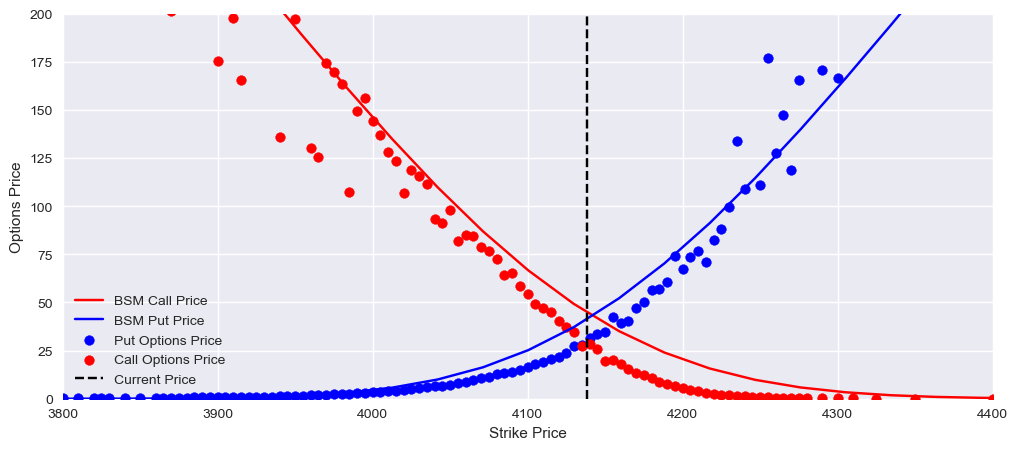

In [166]:
fig = plt.figure(figsize=(12, 5))

plt.plot(K, call_price, label="BSM Call Price", color='r')
plt.plot(K, put_price, label="BSM Put Price", color='b')
plt.scatter(put_options.index, put_options['lastPrice'], label="Put Options Price", color='b')
plt.scatter(call_options.index, call_options['lastPrice'], label="Call Options Price", color='r')
plt.vlines(S0, 0, np.max(call_price), color='k', linestyle='--', label="Current Price")

plt.legend()

plt.xlabel("Strike Price")
plt.ylabel("Options Price")
plt.xlim([3800, 4400])
plt.ylim([0, 200])

plt.show()

# Constructing a strategy 

We are now in a position to start playing around with a simple strategy. The idea is to create a combination of by and call options that create a risk profile which looks like a top hat around the current price of the S&P 500 index. This will ensure that we are hedged against large movements in the index, but still allow us to profit from small movements in either direction. The point of this strategy is to serve as a base for day-to-day trading where movements on the order of a few percent are common, but large movements are rare.

From the Chebyshev inequality, we know that the probability of a random variable $X$ being within $k$ standard deviations of the mean is at least $1 - 1/k^2$. We can use this to construct a portfolio of options that will ensure that the probability of the S&P 500 index being within a certain range is at least some value. We will be interested in the case of $k=2$ standard deviations, which corresponds to a probability of at least $1 - 1/4 = 0.75$. Thus we would expect the S&P 500 index to be within $2\sigma$ of the mean 75% of the time.

Here we will buy K1 and K4 and short K2 and K3

Text(0.5, 0, 'Stock Price')

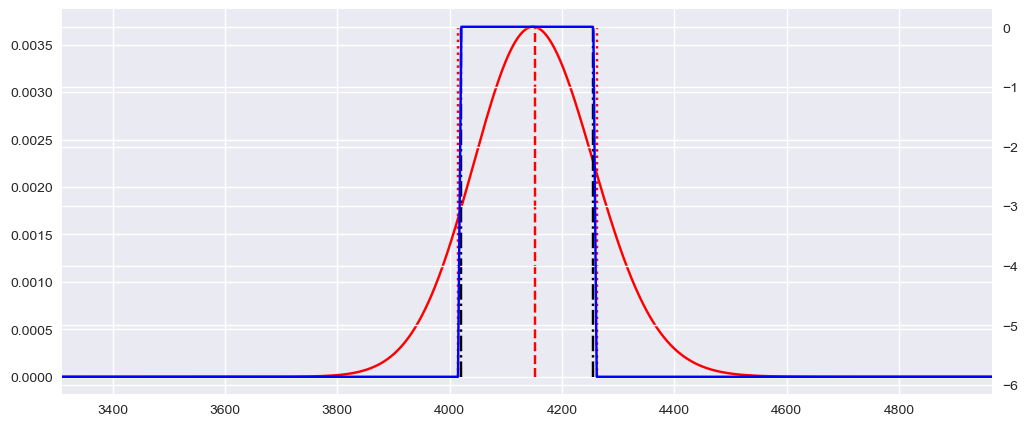

In [162]:
k1 = 1.05
k2 = 1

PLK, [K1, K2, K3, K4] = options_bet(k1, k2, S0, s, s_std, tau, r, sigma_std)


fig = plt.figure(figsize=(12, 5))

plt.plot(s, s_est, color='r', label="Posterior Distribution")
plt.vlines(s_mean, 0, np.max(s_est), color='r', linestyle='--', label="Posterior Mean")
plt.vlines(K1, 0, np.max(s_est), color='r', linestyle=':', label="Posterior Mean + {}*std".format(k))
plt.vlines(K4, 0, np.max(s_est), color='r', linestyle=':', label="Posterior Mean - {}*std".format(k))
plt.vlines(K2, 0, np.max(s_est), color='k', linestyle='-.', label="Posterior Mean + {}*std".format(k+k2))
plt.vlines(K3, 0, np.max(s_est), color='k', linestyle='-.', label="Posterior Mean - {}*std".format(k+k2))

# create a second axis for profit and loss
ax2 = plt.gca().twinx()

ax2.plot(s, PLK, color='b', label="Profit and Loss")
# plt.ylim(-10, 10)

plt.xlim([0.8*S0, 1.2*S0])

plt.xlabel("Stock Price")


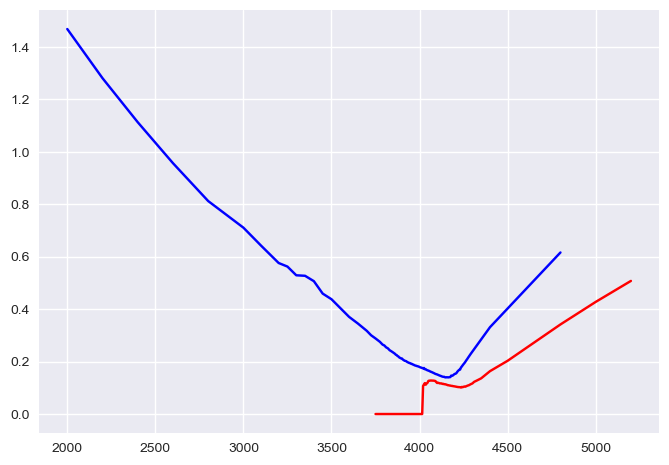

In [164]:
# Plot strike prices vs implied volatility
plt.plot(call_options.index, call_options['impliedVolatility'], label="Call Implied Volatility", color='r')
plt.plot(put_options.index, put_options['impliedVolatility'], label="Put Implied Volatility", color='b')
plt.show()

In [155]:
sigma_mean**2

9.701325155888404e-05